# Theoretical spot modulation with `fleck`

Let's do theoretical spot modulation with [fleck](https://fleck.readthedocs.io/en/latest/)!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fleck import Star
from fleck import generate_spots
import astropy.units as u
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
import seaborn as sns
sns.set_context('paper')

Hard-code the fixed parameters

In [3]:
min_latitude = 60   # deg
max_latitude = 90   # deg

In [4]:
spot_contrast = 0.7
u_ld = [0.5079, 0.2239]

n_phases = 30
n_inclinations = 20000
n_spots = 3

In [5]:
sini_draws = np.linspace(0, 1, n_inclinations, endpoint=False)

In [6]:
inclinations_rad = np.arcsin(sini_draws)
inclinations_deg = np.degrees(np.arccos(sini_draws))
inclinations = inclinations_deg * u.degree

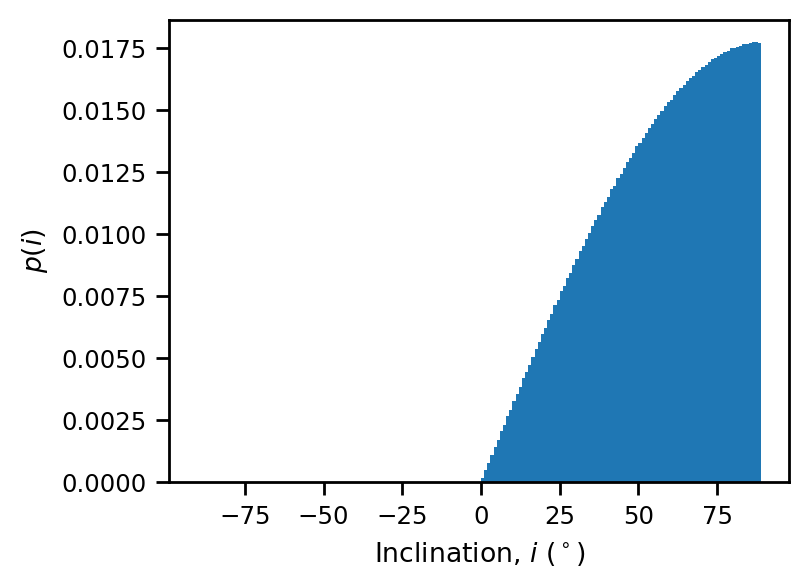

In [7]:
plt.figure(figsize=(4, 3))
plt.hist(inclinations_deg, bins=np.arange(-90, 90, 1), density=True)
plt.xlabel('Inclination, $i$ ($^\circ$)');
plt.ylabel(r'$p(i)$');

In [8]:
mask = inclinations < 15*u.degree
mask.sum()/n_inclinations

0.03405

Only about 3.4% of stars will have inclinations greater than $75^\circ$...

### Cycle 1: Starspots are all in the northern Hemisphere

In [9]:
spot_radius = 0.1   # Rspot/Rstar

In [10]:
star = Star(spot_contrast=spot_contrast, n_phases=n_phases, u_ld=u_ld, rotation_period=7)

In [11]:
lons, lats, radii, inc_stellar = generate_spots(min_latitude, max_latitude,
                                                spot_radius, n_spots,
                                                inclinations=inclinations)

In [12]:
lcs1 = star.light_curve(lons, lats, radii, inc_stellar)

### Cycle 2: Starspots are all in the Sorthern Hemisphere

In [13]:
lons, lats, radii, inc_stellar = generate_spots(-max_latitude, -min_latitude,
                                                spot_radius, n_spots,
                                                inclinations=inclinations)

In [14]:
lcs2 = star.light_curve(lons, lats, radii, inc_stellar)

In [15]:
df_sample = pd.DataFrame({'inc':inclinations_deg, 
                         'cycle1_ptp':100*np.ptp(lcs1, axis=0)/np.mean(lcs1, axis=0),
                         'cycle1_flux':np.mean(lcs1, axis=0), 
                         'cycle2_ptp':100*np.ptp(lcs2, axis=0)/np.mean(lcs2, axis=0),
                         'cycle2_flux':np.mean(lcs2, axis=0)})

Renormalize to seasonal mean

In [16]:
seasonal_average = (df_sample.cycle1_flux+df_sample.cycle2_flux)/2

df_sample['cycle1_flux'] = df_sample['cycle1_flux']/seasonal_average
df_sample['cycle2_flux'] = df_sample['cycle2_flux']/seasonal_average

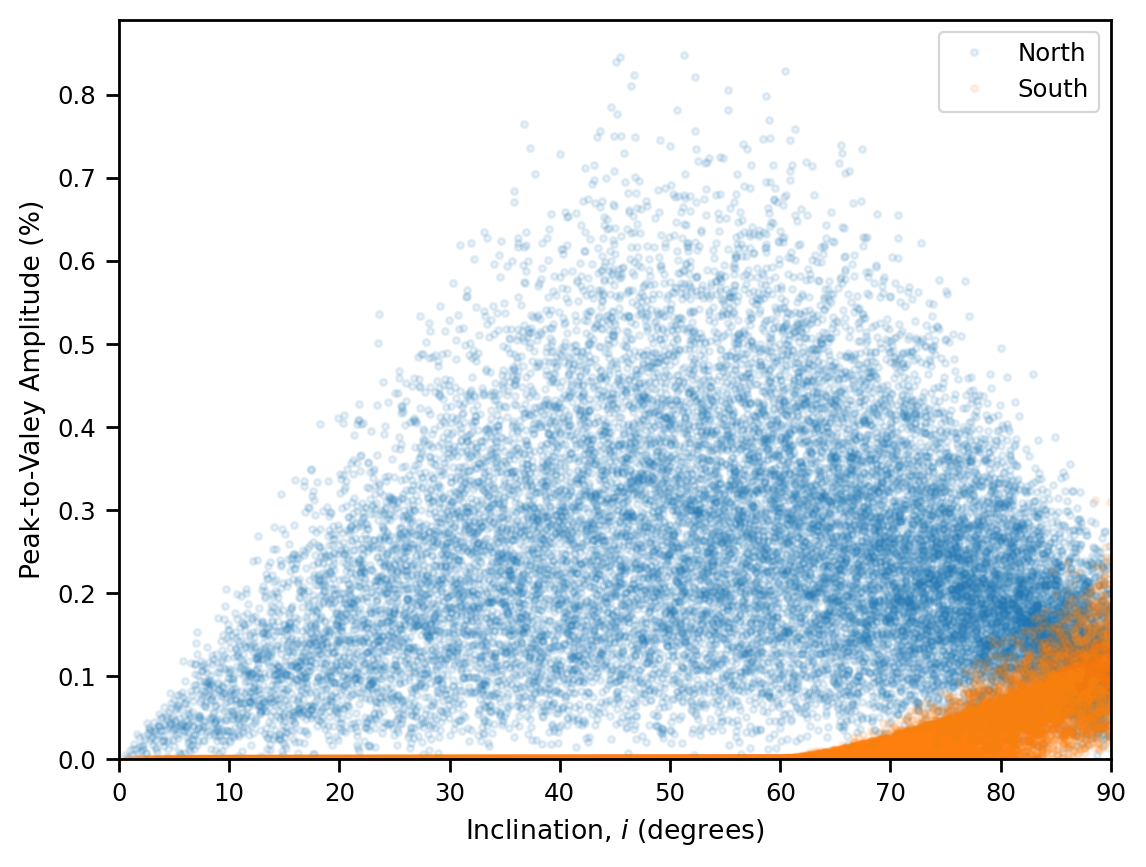

In [17]:
plt.plot(df_sample.inc, df_sample.cycle1_ptp, '.', label='North', alpha=0.1)
plt.plot(df_sample.inc, df_sample.cycle2_ptp, '.', label='South', alpha=0.1)

plt.ylim(0)
plt.xlim(0, 90)
plt.xlabel("Inclination, $i$ (degrees)")
plt.ylabel("Peak-to-Valey Amplitude (%)")
plt.legend()
#plt.xticks([-90,-75,-60,-45,-30,-15,0,])

Neat!  We don't *observe* inclination, so let's reassemble this chart into short/long-term variability.

In [18]:
j=0

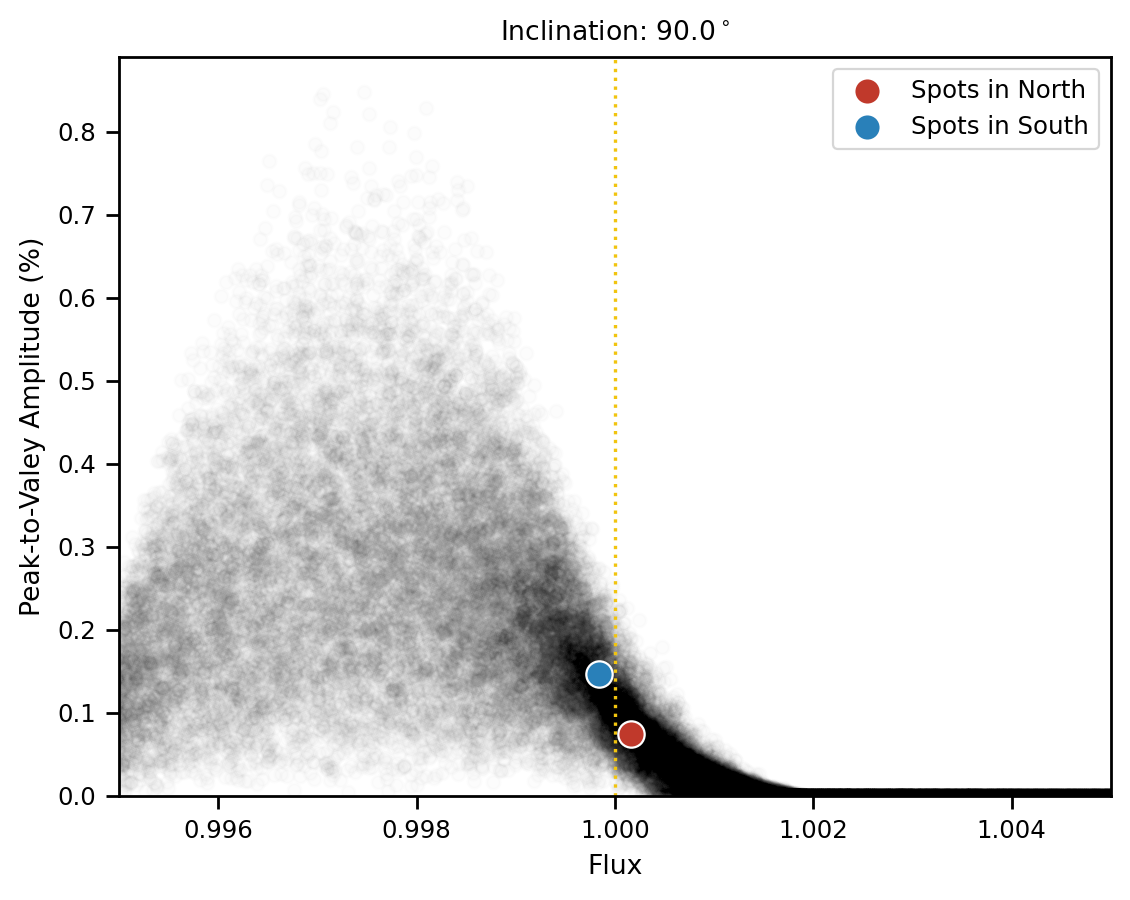

In [19]:
plt.plot(df_sample.cycle1_flux, df_sample.cycle1_ptp, 'ko', alpha=0.01)
plt.plot(df_sample.cycle2_flux, df_sample.cycle2_ptp, 'ko', alpha=0.01)

draw = df_sample.iloc[j]
plt.scatter(draw.cycle1_flux, draw.cycle1_ptp, marker='o',  ec='w',zorder=11,s=90,
         color='#c0392b', alpha=1, label='Spots in North')
plt.scatter(draw.cycle2_flux, draw.cycle2_ptp, marker='o', ec='w', zorder=11,s=90,
         color='#2980b9', alpha=1, label='Spots in South')
plt.title('Inclination: {:0.1f}$^\circ$'.format(draw.inc))

plt.axvline(1.0, color='#f1c40f', linestyle='dotted')
plt.ylim(0)
plt.xlim(0.995, 1.005)
plt.xlabel("Flux")
plt.ylabel("Peak-to-Valey Amplitude (%)")
plt.legend()

j+=50

## Make the control sample!

The control sample is solar-like: more spots at solar maximum, and fewer spots at solar minimum.  We could also change the latitude...

#### Stellar maximum: Big spots

In [20]:
n_spots = 3
spot_contrast = 0.7

In [21]:
lons1, lats1, radii1, inc_stellar = generate_spots(min_latitude, max_latitude,
                                                spot_radius, n_spots,
                                                inclinations=inclinations)

In [22]:
lons2, lats2, radii2, inc_stellar = generate_spots(-max_latitude, -min_latitude,
                                                spot_radius, n_spots,
                                                inclinations=inclinations)

In [23]:
lons = np.vstack([lons1, lons2])
lats = np.vstack([lats1, lats2])
radii = np.vstack([radii1, radii2])

In [24]:
lcs1 = star.light_curve(lons, lats, radii, inc_stellar)

#### Stellar minimum: Smaller spots

In [25]:
n_spots = 3
spot_radius = 0.1/3   # Rspot/Rstar

In [26]:
lons1, lats1, radii1, inc_stellar = generate_spots(min_latitude, max_latitude,
                                                spot_radius, n_spots,
                                                inclinations=inclinations)

In [27]:
lons2, lats2, radii2, inc_stellar = generate_spots(-max_latitude, -min_latitude,
                                                spot_radius, n_spots,
                                                inclinations=inclinations)

In [28]:
lons = np.vstack([lons1, lons2])
lats = np.vstack([lats1, lats2])
radii = np.vstack([radii1, radii2])

In [29]:
lcs2 = star.light_curve(lons, lats, radii, inc_stellar)

In [30]:
df_control = pd.DataFrame({'inc':inclinations_deg, 
                         'cycle1_ptp':100*np.ptp(lcs1, axis=0)/np.mean(lcs1, axis=0),
                         'cycle1_flux':np.mean(lcs1, axis=0), 
                         'cycle2_ptp':100*np.ptp(lcs2, axis=0)/np.mean(lcs2, axis=0),
                         'cycle2_flux':np.mean(lcs2, axis=0)})

In [31]:
seasonal_average = (df_control.cycle1_flux+df_control.cycle2_flux)/2

df_control['cycle1_flux'] = df_control['cycle1_flux']/seasonal_average
df_control['cycle2_flux'] = df_control['cycle2_flux']/seasonal_average

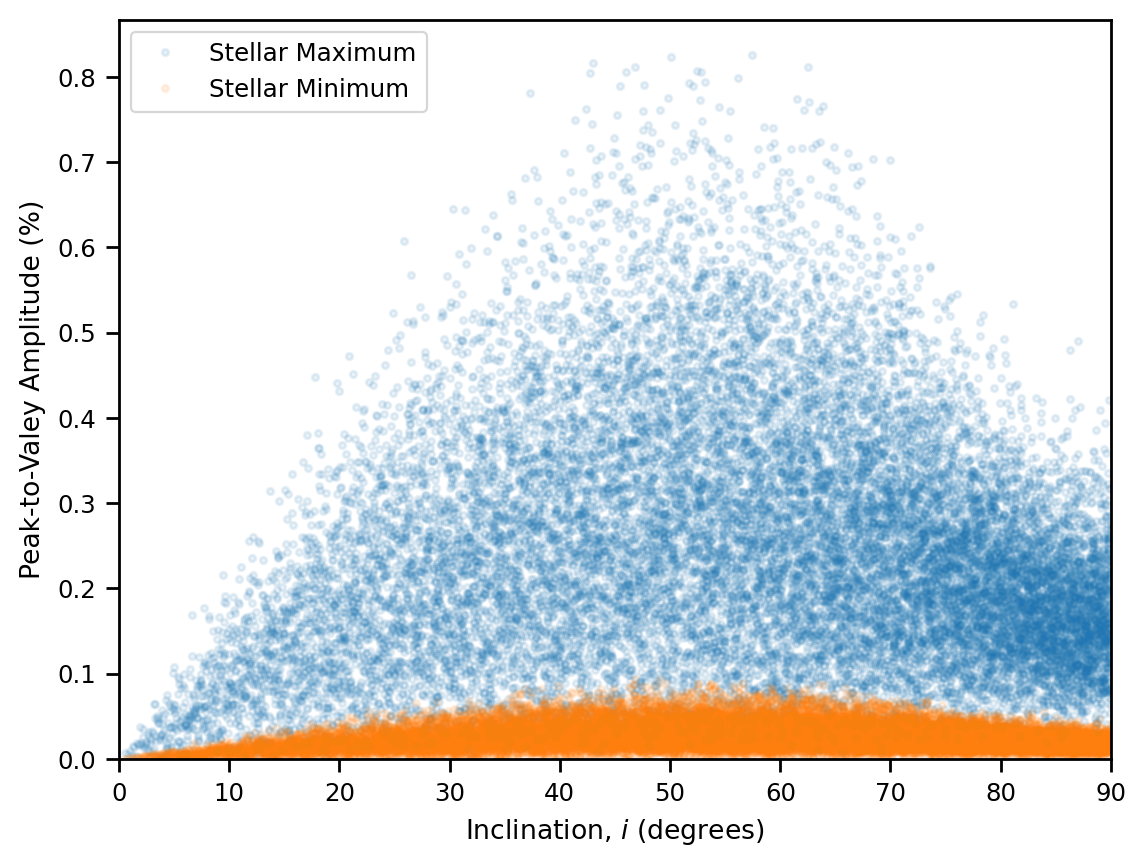

In [32]:
plt.plot(df_control.inc, df_control.cycle1_ptp, '.', label='Stellar Maximum', alpha=0.1)
plt.plot(df_control.inc, df_control.cycle2_ptp, '.', label='Stellar Minimum', alpha=0.1)

plt.ylim(0)
plt.xlim(0, 90)
plt.xlabel("Inclination, $i$ (degrees)")
plt.ylabel("Peak-to-Valey Amplitude (%)")
plt.legend()
#plt.xticks([-90,-75,-60,-45,-30,-15,0,])

In [33]:
j=0

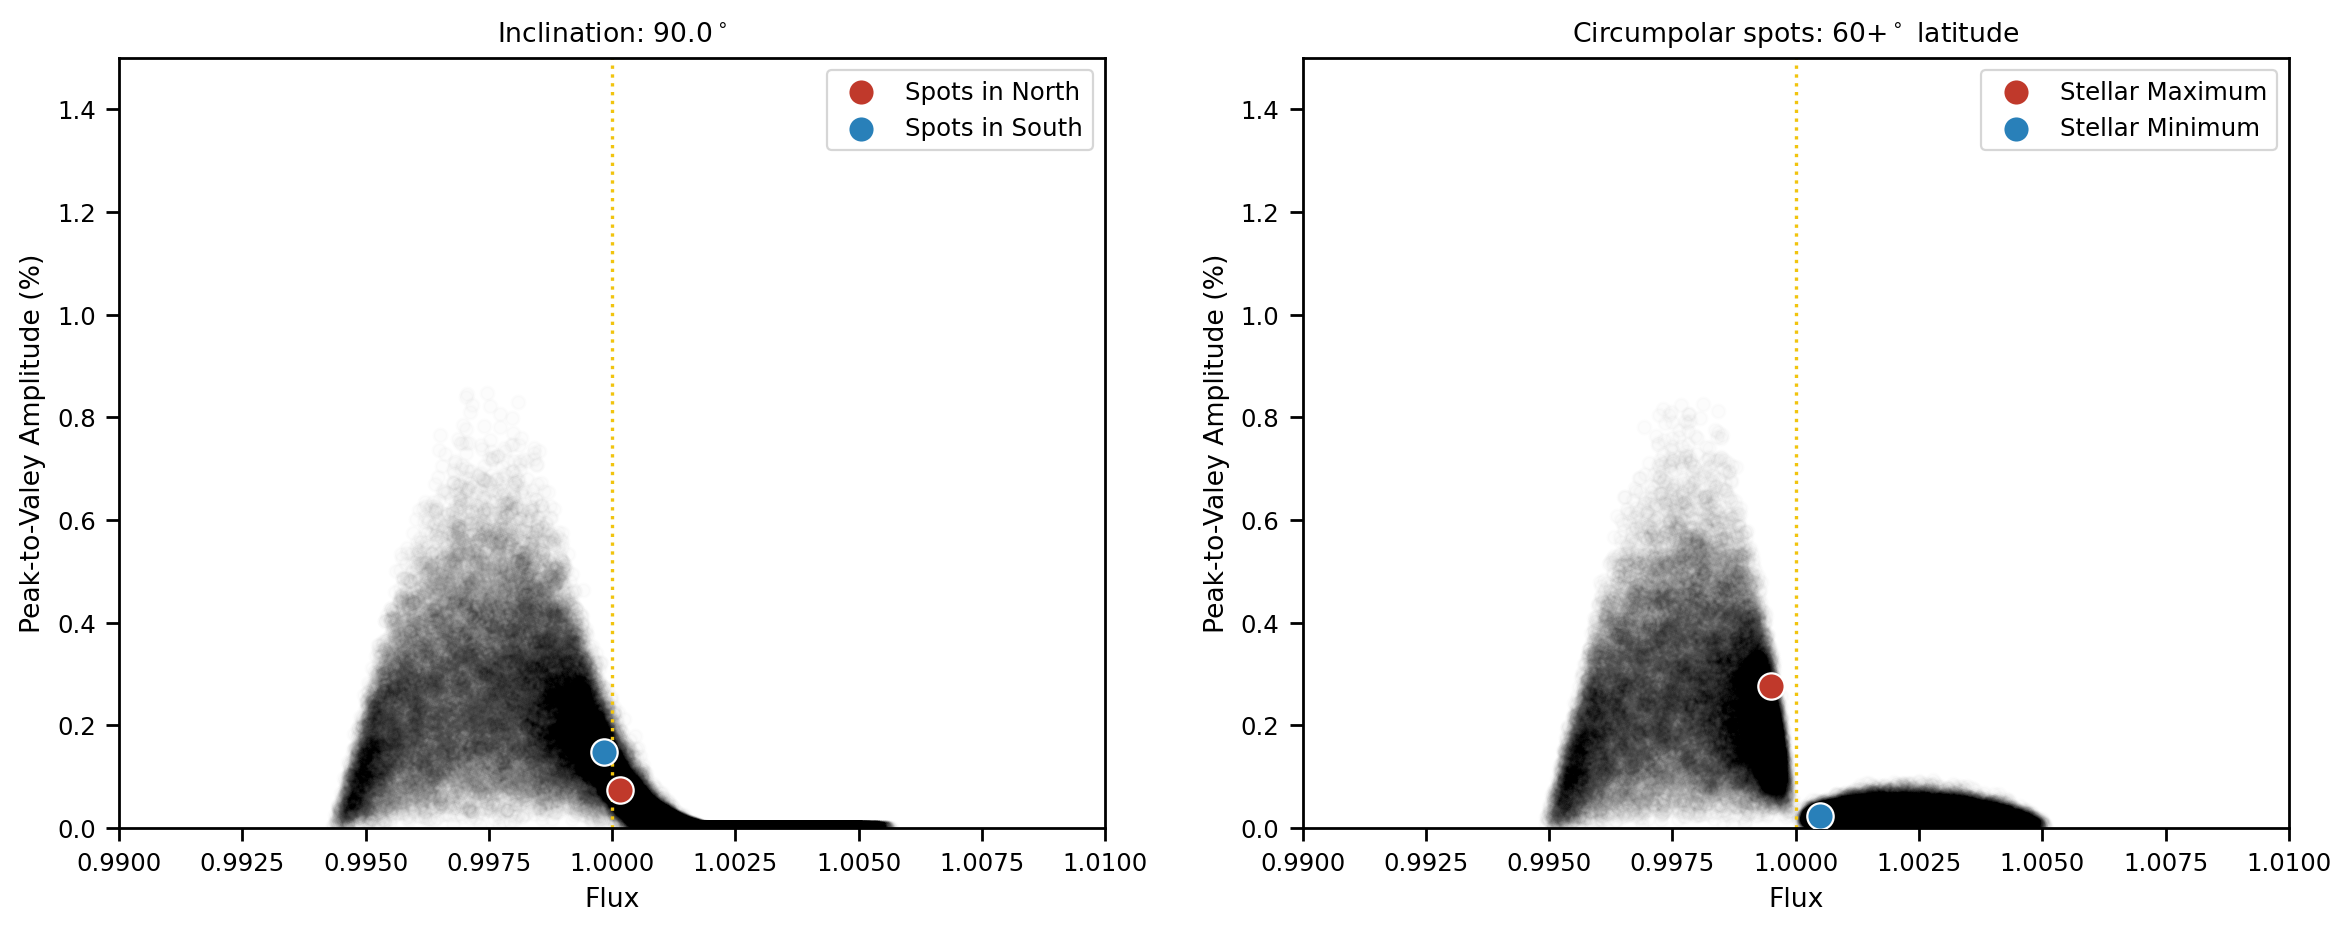

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

axes[0].plot(df_sample.cycle1_flux, df_sample.cycle1_ptp, 'ko', alpha=0.01)
axes[0].plot(df_sample.cycle2_flux, df_sample.cycle2_ptp, 'ko', alpha=0.01)

draw = df_sample.iloc[j]
axes[0].scatter(draw.cycle1_flux, draw.cycle1_ptp, marker='o',  ec='w',zorder=11,s=90,
         color='#c0392b', alpha=1, label='Spots in North')
axes[0].scatter(draw.cycle2_flux, draw.cycle2_ptp, marker='o', ec='w', zorder=11,s=90,
         color='#2980b9', alpha=1, label='Spots in South')
axes[0].set_title('Inclination: {:0.1f}$^\circ$'.format(draw.inc))

axes[0].axvline(1.0, color='#f1c40f', linestyle='dotted')
axes[0].set_ylim(0, 1.5)
axes[0].set_xlim(0.99, 1.01)
axes[0].set_xlabel("Flux")
axes[0].set_ylabel("Peak-to-Valey Amplitude (%)")
axes[0].legend()


axes[1].plot(df_control.cycle1_flux, df_control.cycle1_ptp, 'o',color='k', alpha=0.01)
axes[1].plot(df_control.cycle2_flux, df_control.cycle2_ptp, 'o',color='k', alpha=0.01)

draw2 = df_control.iloc[j]
axes[1].scatter(draw2.cycle1_flux, draw2.cycle1_ptp, marker='o',  ec='w',zorder=11,s=90,
         color='#c0392b', alpha=1, label='Stellar Maximum')
axes[1].scatter(draw2.cycle2_flux, draw2.cycle2_ptp, marker='o', ec='w', zorder=11,s=90,
         color='#2980b9', alpha=1, label='Stellar Minimum')
axes[1].set_title('Circumpolar spots: 60+$^\circ$ latitude')

axes[1].axvline(1.0, color='#f1c40f', linestyle='dotted')
axes[1].set_ylim(0, 1.5)
axes[1].set_xlim(0.99, 1.01)
axes[1].set_xlabel("Flux")
axes[1].set_ylabel("Peak-to-Valey Amplitude (%)")
axes[1].legend()


plt.savefig('../../paper/figures/fleck_polar_spots.png', dpi=300, bbox_inches='tight')

j+=10

Neat! This plot shows that the control sample can be used to distinguish a hemispheric reversal.